In [1]:
%cd ..

/home/jovyan/workspace/models/instance-segmentation/yolov7-mask


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from detectron2.layers import paste_masks_in_image
from detectron2.modeling.poolers import ROIPooler
from detectron2.structures import Boxes
from detectron2.utils.memory import retry_if_cuda_oom
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import (
    non_max_suppression_mask_conf,
    non_max_suppression,
    non_max_suppression_att,
    merge_bases,
)

/home/jovyan/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with open("data/hyp.scratch.mask.yaml") as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)
weigths = torch.load("./weights/yolov7-mask.pt")
model = weigths["model"]
model = model.half().to(device)
_ = model.eval()

In [49]:
# PATH = "./inference/images/bus.jpg"
PATH = "./inference/images/horses.jpg"
# PATH = "./inference/images/image1.jpg"
# PATH = "./inference/images/image2.jpg"
# PATH = "./inference/images/image3.jpg"
# PATH = "./inference/images/zidane.jpg"

In [50]:
image = cv2.imread(PATH)
image = letterbox(image, 640, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)
image = image.half()

output = model(image)

/home/jovyan/.local/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [51]:
inf_out, train_out, attn, mask_iou, bases, sem_output = (
    output["test"],
    output["bbox_and_cls"],
    output["attn"],
    output["mask_iou"],
    output["bases"],
    output["sem"],
)

In [52]:
inf_out.shape, attn.shape, bases.shape, sem_output.shape

(torch.Size([1, 17640, 85]),
 torch.Size([1, 17640, 980]),
 torch.Size([1, 4, 112, 160]),
 torch.Size([1, 1, 112, 160]))

In [53]:
hyp["mask_resolution"] = 112

In [54]:
print(bases.shape)
print(sem_output.shape)
bases = torch.cat([bases, sem_output], dim=1)
print(bases.shape)
nb, _, height, width = image.shape
names = model.names

pooler_scale = model.pooler_scale

pooler = ROIPooler(
    output_size=hyp["mask_resolution"],
    scales=(pooler_scale,),
    sampling_ratio=0,
    pooler_type="ROIAlignV2",
    canonical_level=2,
)

torch.Size([1, 4, 112, 160])
torch.Size([1, 1, 112, 160])
torch.Size([1, 5, 112, 160])


In [55]:
attn.shape

torch.Size([1, 17640, 980])

In [56]:
output, output_att = non_max_suppression_att(
    inf_out, attn, conf_thres=0.25, iou_thres=0.65
)
output[0].shape, output_att[0].shape

(torch.Size([5, 6]), torch.Size([5, 980]))

In [57]:
bbox = output[0][:, :4]
conf = output[0][:, 4]
cls = output[0][:, 5]

In [58]:
print(bases.shape)
print(bbox.shape)

pooled_bases = pooler([bases], [Boxes(bbox)])
pooled_bases.shape

torch.Size([1, 5, 112, 160])
torch.Size([5, 4])


torch.Size([5, 5, 112, 112])

In [59]:
a = output_att[0]
print(a.shape)

pred_masks = (
    merge_bases(pooled_bases, a, hyp["attn_resolution"], hyp["num_base"])
    .view(a.shape[0], -1)
    .sigmoid()
)
pred_masks.shape

torch.Size([5, 980])


torch.Size([5, 12544])

In [60]:
original_pred_masks = pred_masks.view(
    -1, hyp["mask_resolution"], hyp["mask_resolution"]
)
print(original_pred_masks.shape)

torch.Size([5, 112, 112])


In [61]:
bboxes = Boxes(bbox)

pred_masks = retry_if_cuda_oom(paste_masks_in_image)(
    original_pred_masks, bboxes, (height, width), threshold=0.5
)
pred_masks_np = pred_masks.detach().cpu().numpy()

pred_cls = cls.detach().cpu().numpy()
pred_conf = conf.detach().cpu().numpy()

nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

nbboxes = bboxes.tensor.detach().cpu().numpy().astype(np.int)
pnimg = nimg.copy()

In [62]:
for one_mask, bbox, cls, conf in zip(pred_masks_np, nbboxes, pred_cls, pred_conf):
    if conf < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5
    # pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)

    # label = '%s %.3f' % (names[int(cls)], conf)
    # t_size = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]
    # c2 = bbox[0] + t_size[0], bbox[1] - t_size[1] - 3
    # pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), c2, color, -1, cv2.LINE_AA)  # filled
    # pnimg = cv2.putText(pnimg, label, (bbox[0], bbox[1] - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)

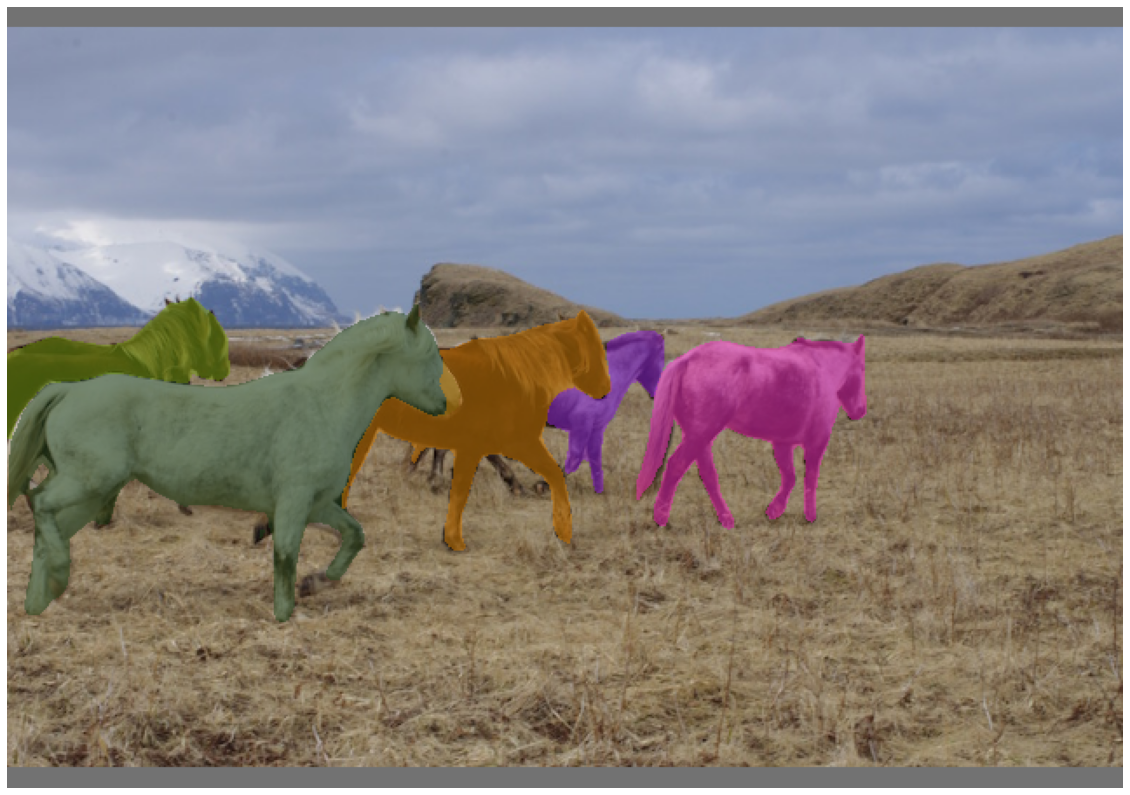

In [63]:
# coco example
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(pnimg)
plt.show()